In [ ]:
# calculate snow features from weather record
# particularly, we will calcualte 
# 1. snow flag per store per date, it can take 0 or 1
# 2. snow_weekly_count. a rolling window, calculate number of days with snow within a week for every store
# 3. first_snow, the date that first snow of the year occur. Here, the first snow is defined as the first snow in fall/winter,so snow in early spring doea not count
# 4. time perioed with repect to the first snow of the year, it includes 1 week, 1 month, and the number of days after the first snow for two weeks

# this can be updated daily 

In [1]:
# import libraries
import pandas as pd
import numpy as np

In [53]:
# get full calendar with store code
def get_full_calendar(raw_store_attribute_df,start_date = '2017-01-01',end_date = '2020-06-30'):
    full_calendar = pd.merge(raw_store_attribute_df[['store_code']].assign(key=1),
                        pd.DataFrame(pd.date_range(start= start_date, end= end_date), columns=["date"]).assign(key=1),
                        how='left').drop('key',1)
    return full_calendar

def get_snow_flag (raw_snow_data,full_calendar):
    # get full calendar
    raw_snow_data = pd.merge(full_calendar,raw_snow_data,how = 'left', on = ['store_code','date']).fillna(0)

    # snow flag
    raw_snow_data['is_snow'] = np.where(raw_snow_data['snowfall_inches']>0,1,0)
    return raw_snow_data

def get_rolling_snow_count_weekly (raw_snow_data):
    # rolling snow count within a week
    raw_snow_data['snow_count_weekly'] = raw_snow_data['is_snow'].rolling(7, min_periods=7).sum().fillna(0).shift(periods = 1,fill_value = 0)
    return raw_snow_data
    
    
def get_first_now_of_the_year(raw_snow_data):
    # convert date time to year and month
    raw_snow_data['year'] = raw_snow_data['date'].dt.year
    raw_snow_data['month'] = raw_snow_data['date'].dt.month
    # first snow
    raw_snow_data ['first_snow'] = 0

    for cur_store in raw_snow_data.store_code.unique():
        cur_weather = raw_snow_data.loc[raw_snow_data['store_code'] == cur_store]
        for cur_year in cur_weather.year.unique():
            if (sum(cur_weather.loc[(cur_weather['year'] == cur_year) & (cur_weather['month'] >8 )][
                        'snowfall_inches'].ne(0)) > 0):
                m = cur_weather.loc[(cur_weather['year'] == cur_year) & (cur_weather['month'] > 8)][
                    'snowfall_inches'].ne(0).idxmax()
                raw_snow_data['first_snow'][m] = 1
    
    return raw_snow_data

def get_first_snow_period(raw_snow_data):
    # calculate one week, one month within the first snow of the year
    raw_snow_data['previous_first_snow_one_week'] = raw_snow_data['first_snow'].rolling(7,min_periods = 1).max().fillna(0).shift(periods = 1,fill_value = 0)
    raw_snow_data['previous_first_snow_one_month']= raw_snow_data['first_snow'].rolling(30,min_periods = 1).max().fillna(0).shift(periods = 1,fill_value = 0)
    # calculate the number of days away from the first snow of the year after it happens
    raw_snow_data['previous_first_snow_two_weeks'] = raw_snow_data['first_snow'].rolling(14,min_periods = 1).max().fillna(0).shift(periods = 1,fill_value = 0)
    raw_snow_data['previous_first_snow_rolling_two_weeks'] = raw_snow_data['previous_first_snow_two_weeks'].rolling(14,min_periods = 1).sum().fillna(0).shift(periods = 1,fill_value = 0)  
    return raw_snow_data

def get_snow_feature(raw_snow_data,raw_store_attribute_df,start_date = '2017-01-01', end_date = '2020-06-30'):
    # full calendar
    full_calendar = get_full_calendar(raw_store_attribute_df)
    # snow flag
    raw_snow_data = get_snow_flag(raw_snow_data,full_calendar)
    # snow weekly count
    raw_snow_data = get_rolling_snow_count_weekly(raw_snow_data)
    # first snow of the year
    raw_snow_data = get_first_now_of_the_year(raw_snow_data)
    # first snow period
    raw_snow_data = get_first_snow_period(raw_snow_data)
    # return only relevant columns
    col = ['date','store_code','first_snow','previous_first_snow_rolling_two_weeks',
           'snow_count_weekly','previous_first_snow_one_week','previous_first_snow_one_month']
    return raw_snow_data[col]

In [54]:
# read weather record and store attribute data
weather_record_df = pd.read_csv('weather_daily_actuals.csv')
store_attribute_df = pd.read_csv('final_store_attributes.csv')

# focus on snow features
raw_snow_data = weather_record_df[['date','store_code','snowfall_inches']]
raw_snow_data['date'] = pd.to_datetime(raw_snow_data['date'],format = '%Y%m%d')

# calculate snow featuers
snow_feature_df = get_snow_feature(raw_snow_data,store_attribute_df,start_date = '2017-01-01', end_date = '2020-06-30')

/Users/liyue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/liyue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
# compare with old data
snow_old_df = pd.read_csv('/Users/liyue/Downloads/snow_feature_1.csv')
snow_old_df['date'] = pd.to_datetime(snow_old_df['date'])

In [56]:
cur_store = 'COD 14'
snow_new = snow_feature_df.loc[snow_feature_df['store_code'] == cur_store]
snow_old = snow_old_df.loc[snow_old_df['store_code'] == cur_store]

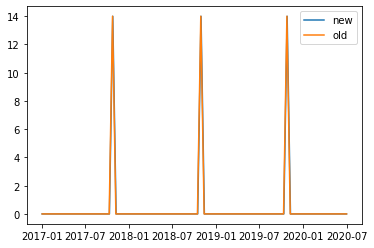

In [57]:
import matplotlib.pyplot as plt
plt.plot(snow_new['date'],snow_new['previous_first_snow_rolling_two_weeks'])
plt.plot(snow_old['date'],snow_old['previous_first_snow_rolling_two_weeks'])
plt.legend(['new','old'])